# Red Wine Quality

Kaggle link: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

WandB project: https://wandb.ai/fischly/simple_regression/table?workspace=user-fischly

First, we need to import Pytorch and other dependencies

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils import data

import wandb

num_epochs = 512
lr = 1e-5
batch_size = 32

wandb.init(project="simple_regression", config={
    'num-epochs': num_epochs,
    'learning-rate': lr,
    'batch-size': batch_size
})

loss,█▇▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.63934


# Data Analysis and Processing

In [41]:
train_data = pd.read_csv('winequality-red.csv')
train_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [42]:
train_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Show distribution of the target variable: quality

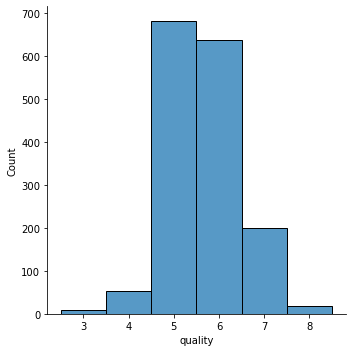

In [43]:
sns.displot(data=train_data, x='quality', discrete=True)

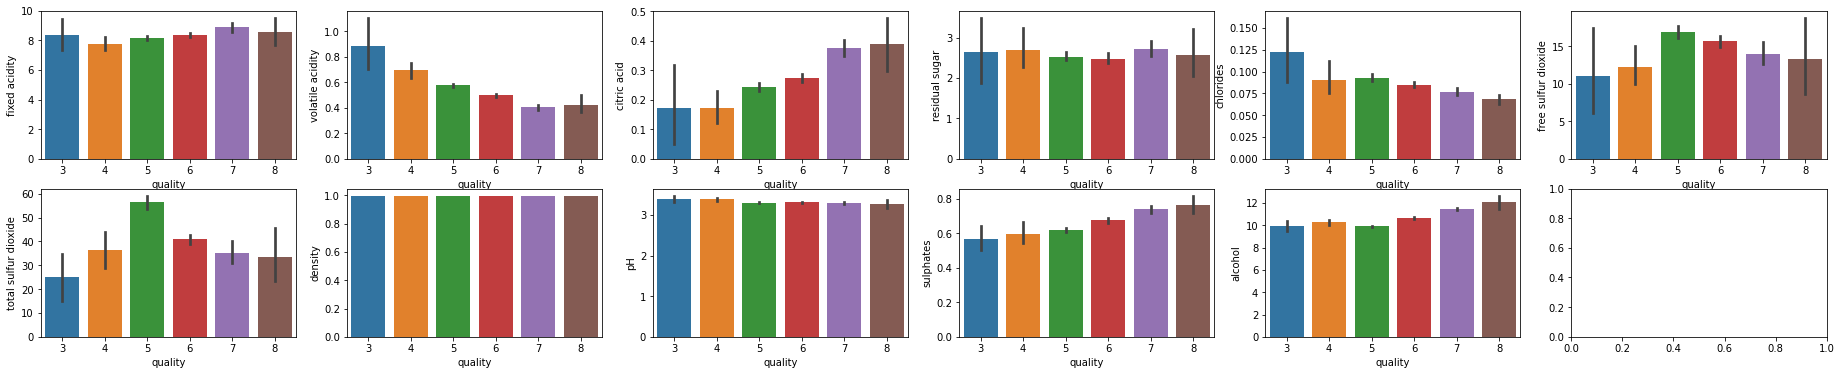

In [44]:
# create a plot consisting of 12 suplots, with two rows and six columns
fig, axes = plt.subplots(2, 6, figsize=(32, 6))

# remove target variable (quality)
features = train_data.iloc[:, 0:-1]

# for each feature, create a barplot with quality on the x-axis
for i, feature in enumerate(features.columns):
    sns.barplot(data=train_data, x='quality', y=feature, ax=axes[i // 6, i % 6])

We can see, that some features like `volatile acidity`, `citric acid`, `sulphates` and `alcohol` seem to correlate with the wine quality, while the other features don't show that big of a correlation.

### Utility functions

In [45]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))

    import random
    random.shuffle(indices)

    # iterate over all examples, in batch_size sized steps
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])

        yield features[batch_indices], labels[batch_indices]


# X: examples, w: weights, b: bias
def linreg(X, w, b):
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2


def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

We need to separate features from target

In [46]:
# number of examples
n_train = train_data.shape[0]

# remove first feature (fixed acidity) and target variable (quality) from the train set
all_features = train_data.iloc[:, 1:-1]
# "normalize" each feature. that way, each feature has the mean at 0 and a standard deviation of 1 
# all_features = all_features.apply(lambda x: (x - x.mean()) / (x.std()))

# convert the features into a tensor
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_features

tensor([[ 0.7000,  0.0000,  1.9000,  ...,  3.5100,  0.5600,  9.4000],
        [ 0.8800,  0.0000,  2.6000,  ...,  3.2000,  0.6800,  9.8000],
        [ 0.7600,  0.0400,  2.3000,  ...,  3.2600,  0.6500,  9.8000],
        ...,
        [ 0.5100,  0.1300,  2.3000,  ...,  3.4200,  0.7500, 11.0000],
        [ 0.6450,  0.1200,  2.0000,  ...,  3.5700,  0.7100, 10.2000],
        [ 0.3100,  0.4700,  3.6000,  ...,  3.3900,  0.6600, 11.0000]])

In [47]:
# reshape target data to be a column vector
trains_labels = train_data.quality.values.reshape(-1, 1)
trains_labels

array([[5],
       [5],
       [5],
       ...,
       [6],
       [5],
       [6]], dtype=int64)

In [48]:
trains_mean = trains_labels.mean()
trains_std = trains_labels.std()

# "normalize" also the target and convert it to a tensor
trains_labels = (trains_labels - trains_mean) / trains_std
train_labels = torch.tensor(trains_labels,
                            dtype=torch.float32)
train_labels

tensor([[-0.7878],
        [-0.7878],
        [-0.7878],
        ...,
        [ 0.4508],
        [-0.7878],
        [ 0.4508]])

## Training

Initialize the weight of the linear regression

In [49]:
n_features = all_features.shape[1]

linear_weights = torch.randn(size=(n_features, 1), requires_grad=True)
bias = torch.zeros(size=(1, 1), requires_grad=True)

linear_weights, bias

(tensor([[ 1.4956],
         [-0.5544],
         [ 1.1866],
         [ 0.2598],
         [-1.3845],
         [-0.1201],
         [-0.1969],
         [ 0.8672],
         [ 0.5733],
         [ 1.0352]], requires_grad=True),
 tensor([[0.]], requires_grad=True))

Training loop

In [50]:
train_features.shape, train_labels.shape

(torch.Size([1599, 10]), torch.Size([1599, 1]))

In [51]:

for i in range(num_epochs):
    for X, y in data_iter(batch_size, train_features, train_labels):
        prediction = linreg(X, linear_weights, bias)
        loss = squared_loss(prediction, y)

        # compute gradient of the (average) loss, with regard to weights and bias
        loss.sum().backward()
        # print('prediction: ', prediction, 'loss: ', loss, 'grad_w:', linear_weights.grad, 'grad_b:', bias.grad)

        # update weights and bias using their gradient
        sgd([linear_weights, bias], lr, batch_size)
        
    # evaluating loss after each batch
    with torch.no_grad():
        train_pred = linreg(train_features, linear_weights, bias)
        train_loss = float(squared_loss(train_pred, train_labels).mean())

        wandb.log({'loss': train_loss})


Get the real predictions

In [52]:
predictions = (predictions * trains_std) + trains_mean
predictions

NameError: name 'predictions' is not defined

Our predictions seem very close to the ground truth!

**To go further**: Stochastic Gradient Descent is not the optimal algorithm in terms of convergeance.
If you are curious, you can read this nice article about an improvement to SGD, momentum and try to implement it: https://distill.pub/2017/momentum/